# EDA

### Imports

In [98]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools, re, spacy, unidecode, warnings
from tqdm import tqdm, tqdm_notebook
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

In [94]:
warnings.filterwarnings('ignore')

In [91]:
nlp = spacy.load("fr_core_news_md")

In [95]:
tqdm.pandas(tqdm_notebook)

### Database loading

In [3]:
%%time
df = pd.read_pickle('data/data.pkl')

CPU times: user 1.23 s, sys: 626 ms, total: 1.86 s
Wall time: 1.9 s


### NaN

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67210 entries, 0 to 67209
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ID              67210 non-null  object        
 1   NUMERO_AFFAIRE  59061 non-null  object        
 2   DATE_DEC        67210 non-null  datetime64[ns]
 3   NATURE          57570 non-null  object        
 4   SIEGE_APPEL     64240 non-null  object        
 5   CONTENU         67210 non-null  object        
 6   SCT             17098 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 3.6+ MB


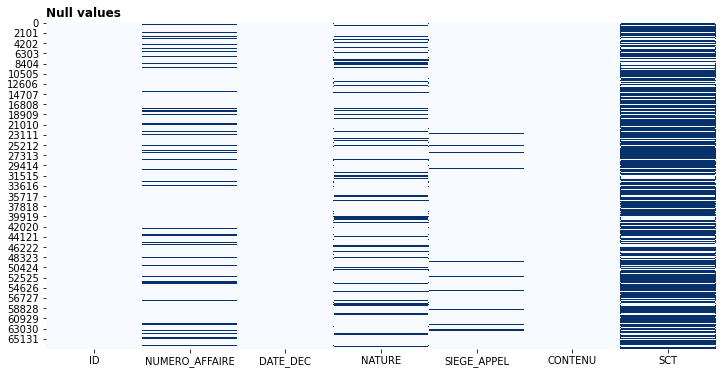

In [42]:
plt.figure(figsize = (12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="Blues")
plt.title('Null values', fontweight = 'bold', loc = 'left')
plt.show()

In [63]:
pd.DataFrame(round(df.isnull().sum() / len(df) * 100, 2), columns = ['% of NaN'])

,% of NaN
ID,0.00
NUMERO_AFFAIRE,12.12
DATE_DEC,0.00
NATURE,14.34
SIEGE_APPEL,4.42
CONTENU,0.00
SCT,74.56


### Duplicates

In [12]:
df.ID.duplicated().sum()

0

### Time distribution

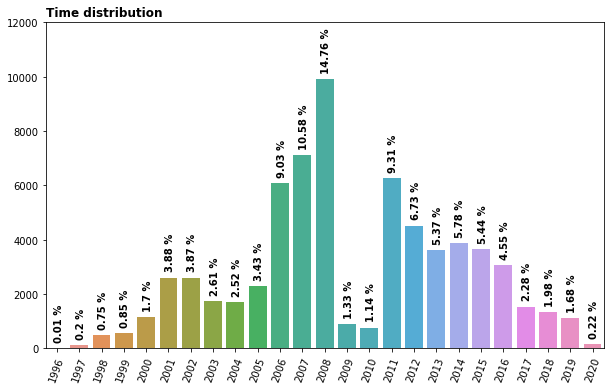

In [69]:
plt.figure(figsize = (10, 6))
sns.barplot(x = df.groupby(df.DATE_DEC.dt.year).count().index,
            y = df.groupby(df.DATE_DEC.dt.year).count()['ID'].values)

for i in range(len(df.DATE_DEC.dt.year.unique())):
    plt.text(x = i - 0.15,
             y = df.groupby(df.DATE_DEC.dt.year).count().ID.values[i] + 300,
             s = f'{round(df.groupby(df.DATE_DEC.dt.year).count().ID.values[i] / len(df) * 100, 2)} %',
             fontweight = 'bold',
             rotation = 90)
    
plt.xlabel(None)
plt.gca().set_ylim([0,12000])
plt.title('Time distribution', loc = 'left', fontweight = 'bold')
plt.xticks(rotation =70)
plt.show()

### Nature of decisions

In [53]:
df.NATURE.value_counts().values.sum()

57570

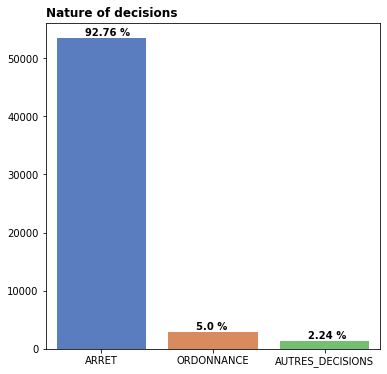

In [79]:
plt.figure(figsize = (6,6))

sns.countplot(df.NATURE, palette = 'muted')
for i in range(len(df.NATURE.value_counts())):
    plt.text(x = i - 0.15, y = df.NATURE.value_counts().values[i] + 500, 
             s = f'{round(df.NATURE.value_counts().values[i] / df.NATURE.value_counts().values.sum() * 100, 2)} %', fontweight = 'bold')
plt.ylabel(None)
plt.xlabel(None)
plt.title('Nature of decisions', fontweight = 'bold', loc = 'left')
plt.show()

### Spatial distribution

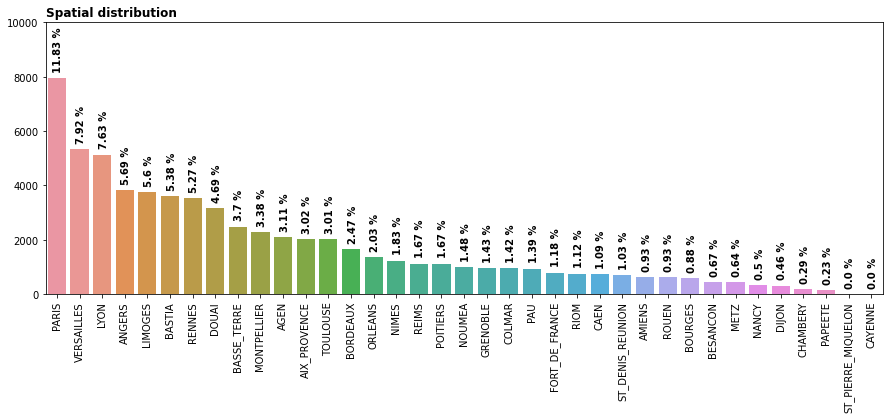

In [85]:
plt.figure(figsize = (15,5))

sns.countplot(df.SIEGE_APPEL, order = df.SIEGE_APPEL.value_counts().index)

for i in range(len(df.SIEGE_APPEL.value_counts())):
    plt.text(x = i - 0.15,
             y = df.SIEGE_APPEL.value_counts().values[i] + 300,
             s = f'{round(df.SIEGE_APPEL.value_counts().values[i] / len(df) * 100, 2)} %',
             fontweight = 'bold',
             rotation = 90)
    
plt.xticks(rotation = 90)
plt.ylabel(None)
plt.xlabel(None)
plt.title('Spatial distribution', fontweight = 'bold', loc ='left')
plt.gca().set_ylim([0,10000])
plt.show()

### Labels

In [86]:
def label_preprocessing(x):
    
    ### cleaning
    x = re.sub(r"(\w)([A-Z][a-z])", r"\1 \2", x)
    x = x.split('\n\n')
    x = [i.split(' - ') for i in x]
    x = [i.strip().lower() for i in itertools.chain.from_iterable(x) if i != '']
    x = [re.sub('null*', '', i).strip() for i in x]
    x = [re.sub('\n*', '', i).strip() for i in x]
    x = [re.sub('jdf*', '', i).strip() for i in x]
    x = ' '.join(x)
    
    ### tokenizer, lemmatizer, remove stop words and non-alphanumeric caracter
    doc = nlp(x)
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]

    return tokens

In [97]:
df['label_tokens'] = df.SCT[df.SCT.notnull()].progress_map(label_preprocessing)

100%|██████████| 17098/17098 [02:56<00:00, 96.97it/s] 


#### Unigram

In [116]:
def freq_counter(tokens):
    corpus = list()
    for token in tokens:
        corpus += list(set(token))
    return corpus, Counter(corpus)

In [117]:
label_corpus, label_counter = freq_counter(df.label_tokens[df.label_tokens.notnull()])

In [121]:
wordcloud = WordCloud(max_font_size=50, max_words=40, background_color="white").generate(' '.join(label_corpus))                                                                          

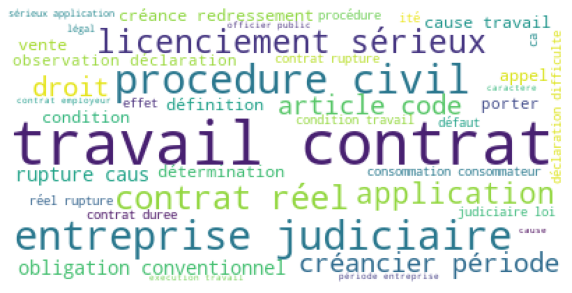

In [124]:
plt.figure(figsize = (10, 15))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [125]:
label_counter.most_common(20)

[('contrat', 3168),
 ('travail', 2790),
 ('condition', 1932),
 ('entreprise', 1630),
 ('civil', 1495),
 ('application', 1480),
 ('difficulte', 1333),
 ('rupture', 1256),
 ('judiciaire', 1195),
 ('responsabilité', 1103),
 ('obligation', 1098),
 ('action', 1067),
 ('loi', 931),
 ('execution', 922),
 ('règle', 895),
 ('bail', 886),
 ('licenciement', 885),
 ('redressement', 836),
 ('général', 828),
 ('procedure', 769)]

#### Bigram

In [126]:
df['label_tokens_join'] = df.label_tokens[df.label_tokens.notnull()].apply(lambda x: ' '.join(x))

In [128]:
vec = CountVectorizer(lowercase = False, ngram_range=(2, 2))
BOW = vec.fit_transform(df.label_tokens_join[df.label_tokens_join.notnull()]).toarray()
bow_df = pd.DataFrame(data=BOW, columns=vec.get_feature_names())

In [132]:
bow_df.sum(axis = 0).sort_values(ascending=False).head(20)

contrat travail            2567
entreprise difficulte      1419
travail rupture            1206
rupture licenciement        873
redressement judiciaire     792
procedure civil             742
règle général               683
travail execution           677
protection consommateur     561
difficulte redressement     547
période observation         500
judiciaire période          488
réel sérieux                449
article code                434
domaine application         423
securite social             418
loi juillet                 408
cause réel                  391
difficulte loi              384
caus cause                  384
dtype: int64

In [133]:
bow_sum = bow_df.sum(axis = 0).sort_values(ascending=False).head(20)

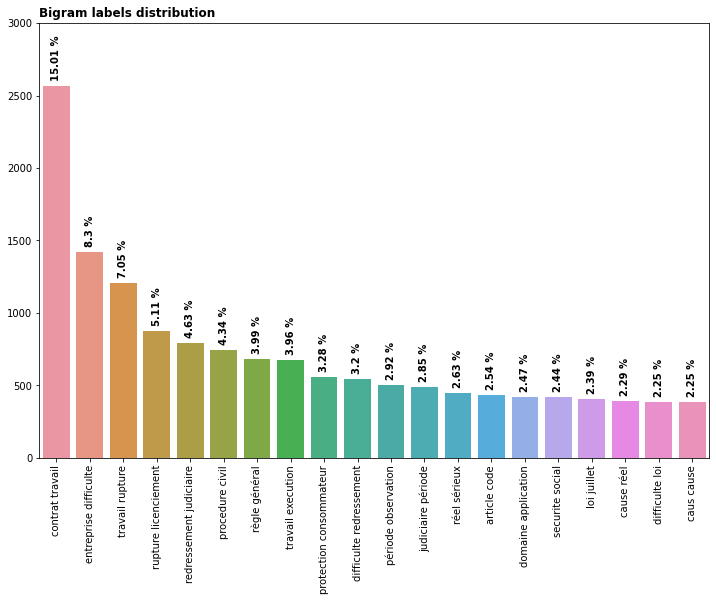

In [159]:
plt.figure(figsize = (12, 8))

sns.barplot(x = bow_sum.index, y = bow_sum.values)
for i in range(20):
    plt.text(x = i - 0.15, 
             y = bow_sum.values[i] + 50,
             s = f'{round(bow_sum.values[i]/170.98, 2)} %',
             fontweight = 'bold',
             rotation = 90)
plt.xticks(rotation = 90)
plt.gca().set_ylim([0, 3000])
plt.title('Bigram labels distribution', fontweight = 'bold', loc = 'left')
plt.show()

### Texts

In [12]:
def preprocess(text):
    ### tokenizer, lemmatizer, remove stop words, non-alphanumeric caracters, and words less than 2 characters long
    doc = nlp(text)
    tokens = [unidecode.unidecode(str(token).lower()) for token in doc if not token.is_stop and token.is_alpha and len(token) > 2]
    return tokens

In [22]:
%%time
df['tokens'] = df.CONTENU.apply(preprocess)

CPU times: user 5h 46min 19s, sys: 1h 1min 4s, total: 6h 47min 23s
Wall time: 7h 10min 44s


In [160]:
%%time
df = pd.read_pickle('tokens.pkl')

CPU times: user 13 s, sys: 11.1 s, total: 24.1 s
Wall time: 31.8 s


In [165]:
words = list()
for text in df.tokens.values:
    words += text
len(words)

63427415

In [167]:
text_corpus, text_counter = freq_counter(df.tokens)

In [168]:
len(text_corpus)

27909080

In [169]:
%%time
wordcloud = WordCloud(width=800, height=400,max_font_size=70, max_words=100,
                      background_color="white").generate(' '.join(text_corpus))

CPU times: user 2min 28s, sys: 1min, total: 3min 29s
Wall time: 3min 58s


In [69]:
wordcloud.to_file("./wordcloud.png")

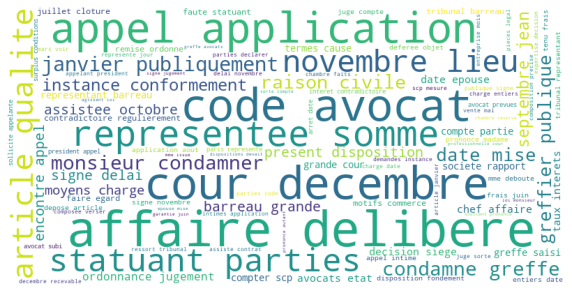

In [170]:
plt.figure(figsize = (10, 15))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [173]:
most_common_words_freq = [(word, round(count/len(df), 2)) for (word, count) in tqdm(text_counter.most_common())]

100%|██████████| 225486/225486 [00:00<00:00, 400408.31it/s]


In [180]:
common_words = [word for (word, count) in most_common_words_freq if count >= 0.2]

In [182]:
len(common_words)

389